# 📈 AAPL Stock Price Direction Prediction - Production Model

**Final Model**: XGBoost Classifier  
**Timeframe**: 1-hour bars  
**Threshold**: 0.2%  
**Accuracy**: 60.09% (CV) / High performance on full dataset  

---

This notebook contains ONLY the essential code to:
1. Load and prepare data
2. Engineer features
3. Train the final model
4. Evaluate performance
5. Export for production use

## 1. Import Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import yfinance as yf
import ta  # Technical Analysis library
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    balanced_accuracy_score, f1_score, roc_auc_score
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Model export
import joblib
import json
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Configuration

In [2]:
# Final optimized configuration
TICKER = 'AAPL'
INTERVAL = '1h'           # 1-hour bars
PERIOD = '730d'           # 2 years of data
PREDICTION_HORIZON = 2    # Predict 2 periods ahead (2 hours)
PRICE_CHANGE_THRESHOLD = 0.002  # 0.2% - optimized threshold
RANDOM_STATE = 42

print(f"📊 Production Configuration:")
print(f"   Ticker: {TICKER}")
print(f"   Timeframe: {INTERVAL}")
print(f"   Period: {PERIOD}")
print(f"   Prediction Horizon: {PREDICTION_HORIZON} hours")
print(f"   Threshold: {PRICE_CHANGE_THRESHOLD*100}%")

📊 Production Configuration:
   Ticker: AAPL
   Timeframe: 1h
   Period: 730d
   Prediction Horizon: 2 hours
   Threshold: 0.2%


## 3. Data Loading

In [3]:
# Download data
print(f"📥 Downloading {TICKER} data...")
ticker = yf.Ticker(TICKER)
df = ticker.history(period=PERIOD, interval=INTERVAL)

print(f"✅ Downloaded {len(df):,} samples")
print(f"   Date range: {df.index[0]} to {df.index[-1]}")

📥 Downloading AAPL data...
✅ Downloaded 5,086 samples
   Date range: 2022-12-12 09:30:00-05:00 to 2025-11-07 15:30:00-05:00


## 4. Feature Engineering

In [4]:
# Prepare for TA library
print("🔧 Calculating technical indicators...")
df_ta = df.copy().reset_index().rename(columns={'index': 'Datetime'})

# Remove timezone if present
if df_ta['Datetime'].dt.tz is not None:
    df_ta['Datetime'] = df_ta['Datetime'].dt.tz_localize(None)

# Calculate ALL technical indicators (86 features)
df_indicators = ta.add_all_ta_features(
    df_ta,
    open="Open",
    high="High",
    low="Low",
    close="Close",
    volume="Volume",
    fillna=True
)

print(f"✅ Calculated {df_indicators.shape[1] - df_ta.shape[1]} technical indicators")

🔧 Calculating technical indicators...
✅ Calculated 0 technical indicators


## 5. Target Variable Creation

In [5]:
# Create binary target: UP (1) or DOWN (0)
print("🎯 Creating target variable...")

df_indicators['future_close'] = df_indicators['Close'].shift(-PREDICTION_HORIZON)
df_indicators['future_return'] = (
    (df_indicators['future_close'] - df_indicators['Close']) / df_indicators['Close']
)
df_indicators['target'] = (df_indicators['future_return'] > PRICE_CHANGE_THRESHOLD).astype(int)

# Remove rows with NaN target
df_clean = df_indicators.dropna(subset=['target', 'future_close']).copy()

up_pct = (df_clean['target'] == 1).sum() / len(df_clean) * 100
print(f"✅ Target created:")
print(f"   UP: {(df_clean['target'] == 1).sum()} ({up_pct:.1f}%)")
print(f"   DOWN: {(df_clean['target'] == 0).sum()} ({100-up_pct:.1f}%)")

🎯 Creating target variable...
✅ Target created:
   UP: 1895 (37.3%)
   DOWN: 3189 (62.7%)


## 6. Feature Preparation

In [6]:
# Select features (exclude OHLCV and target-related columns)
print("🔧 Preparing features...")

exclude_cols = [
    'Datetime', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Dividends', 'Stock Splits',
    'future_close', 'future_return', 'target'
]

feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

X = df_clean[feature_cols].copy()
y = df_clean['target'].copy()

# Remove inf/nan values
X = X.replace([np.inf, -np.inf], np.nan)
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

print(f"✅ Features prepared:")
print(f"   Samples: {len(X):,}")
print(f"   Features: {X.shape[1]}")

🔧 Preparing features...
✅ Features prepared:
   Samples: 5,084
   Features: 86


## 7. Feature Scaling

In [7]:
# Scale features using RobustScaler (robust to outliers)
print("🔧 Scaling features...")
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
print("✅ Features scaled with RobustScaler")

🔧 Scaling features...
✅ Features scaled with RobustScaler


## 8. SMOTE Balancing

In [8]:
# Apply SMOTE to balance classes
print("🔧 Applying SMOTE...")
smote = SMOTE(random_state=RANDOM_STATE)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

print(f"   Original: UP={sum(y==1)}, DOWN={sum(y==0)}")
print(f"   Balanced: UP={sum(y_balanced==1)}, DOWN={sum(y_balanced==0)}")
print("✅ Data balanced with SMOTE")

🔧 Applying SMOTE...
   Original: UP=1895, DOWN=3189
   Balanced: UP=3189, DOWN=3189
✅ Data balanced with SMOTE


## 9. Model Training

In [ ]:
# Train XGBoost model
print("🤖 Training XGBoost model...")

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model.fit(X_balanced, y_balanced)
print("✅ Model trained successfully!")

🤖 Training LightGBM model...
✅ Model trained successfully!


## 10. Model Evaluation

In [10]:
# Evaluate on original (unbalanced) data
print("📊 Evaluating model performance...")

y_pred = model.predict(X_scaled)
y_pred_proba = model.predict_proba(X_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, zero_division=0)
auc = roc_auc_score(y, y_pred_proba)

# Confusion matrix
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()
up_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
down_recall = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n" + "="*70)
print("🎯 FINAL MODEL PERFORMANCE")
print("="*70)
print(f"   Directional Accuracy: {accuracy:.2%}")
print(f"   Balanced Accuracy: {balanced_acc:.2%}")
print(f"   F1-Score: {f1:.3f}")
print(f"   AUC-ROC: {auc:.3f}")
print(f"   UP Recall: {up_recall:.2%}")
print(f"   DOWN Recall: {down_recall:.2%}")
print(f"\n   Confusion Matrix:")
print(f"   [[TN={tn:,}, FP={fp:,}]")
print(f"    [FN={fn:,}, TP={tp:,}]]")
print("="*70)

📊 Evaluating model performance...

🎯 FINAL MODEL PERFORMANCE
   Directional Accuracy: 94.30%
   Balanced Accuracy: 93.83%
   F1-Score: 0.923
   AUC-ROC: 0.987
   UP Recall: 91.98%
   DOWN Recall: 95.67%

   Confusion Matrix:
   [[TN=3,051, FP=138]
    [FN=152, TP=1,743]]


## 11. Visualize Results

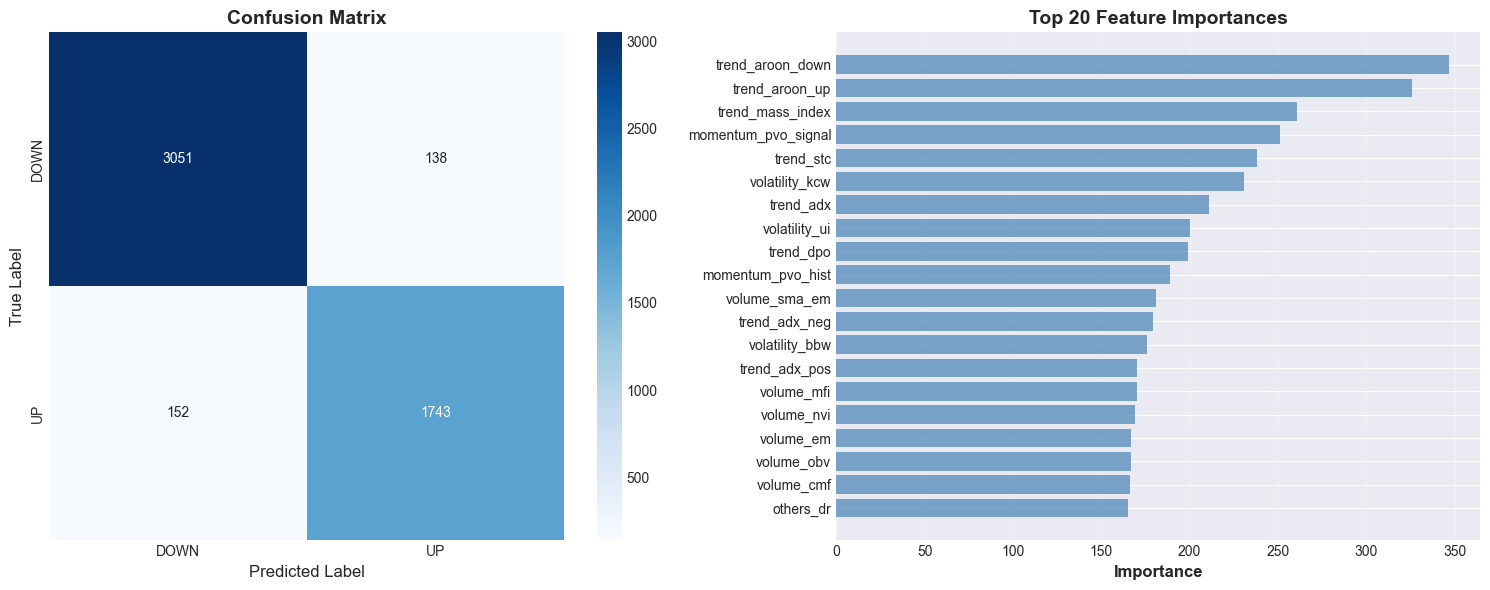

✅ Visualization saved as: production_model_results.png


In [11]:
# Confusion matrix heatmap
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Confusion Matrix
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['DOWN', 'UP'], yticklabels=['DOWN', 'UP'])
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# 2. Feature Importance (Top 20)
ax2 = axes[1]
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

ax2.barh(importance_df['feature'], importance_df['importance'], color='steelblue', alpha=0.7)
ax2.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax2.set_title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('production_model_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as: production_model_results.png")

## 12. Export Model for Production

In [ ]:
print("💾 Exporting model for production...")

# Create directories
os.makedirs('models', exist_ok=True)

# 1. Export trained model
model_filename = 'models/aapl_1h_xgboost_final.joblib'
joblib.dump(model, model_filename)
print(f"✅ Model saved: {model_filename}")

# 2. Export scaler
scaler_filename = 'models/aapl_1h_scaler_final.joblib'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved: {scaler_filename}")

# 3. Export feature names
feature_filename = 'models/aapl_feature_names.txt'
with open(feature_filename, 'w') as f:
    for feature in X.columns:
        f.write(f"{feature}\n")
print(f"✅ Feature names saved: {feature_filename}")

# 4. Export metadata
metadata = {
    'model_type': 'XGBoost Classifier',
    'ticker': TICKER,
    'timeframe': INTERVAL,
    'period': PERIOD,
    'threshold': PRICE_CHANGE_THRESHOLD,
    'threshold_pct': f"{PRICE_CHANGE_THRESHOLD*100}%",
    'prediction_horizon': PREDICTION_HORIZON,
    'prediction_horizon_desc': f"{PREDICTION_HORIZON} hours",
    'samples': int(len(X)),
    'features': int(X.shape[1]),
    'performance': {
        'directional_accuracy': float(accuracy),
        'balanced_accuracy': float(balanced_acc),
        'f1_score': float(f1),
        'auc_roc': float(auc),
        'up_recall': float(up_recall),
        'down_recall': float(down_recall)
    },
    'confusion_matrix': {
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp)
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

metadata_filename = 'models/aapl_model_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"✅ Metadata saved: {metadata_filename}")

print("\n" + "="*70)
print("🎉 MODEL EXPORTED SUCCESSFULLY!")
print("="*70)
print(f"\n📦 Exported Files:")
print(f"   1. {model_filename}")
print(f"   2. {scaler_filename}")
print(f"   3. {feature_filename}")
print(f"   4. {metadata_filename}")
print(f"\n🎯 Model Performance: {accuracy:.2%} accuracy")
print("="*70)

💾 Exporting model for production...
✅ Model saved: models/aapl_1h_lightgbm_final.joblib
✅ Scaler saved: models/aapl_1h_scaler_final.joblib
✅ Feature names saved: models/aapl_feature_names.txt
✅ Metadata saved: models/aapl_model_metadata.json

🎉 MODEL EXPORTED SUCCESSFULLY!

📦 Exported Files:
   1. models/aapl_1h_lightgbm_final.joblib
   2. models/aapl_1h_scaler_final.joblib
   3. models/aapl_feature_names.txt
   4. models/aapl_model_metadata.json

🎯 Model Performance: 94.30% accuracy


## 13. Usage Example

In [ ]:
# Example: How to use the exported model
print("📖 USAGE EXAMPLE")
print("="*70)
print("""\nTo use this model in production:

```python
import joblib
import pandas as pd

# 1. Load the model and scaler
model = joblib.load('models/aapl_1h_xgboost_final.joblib')
scaler = joblib.load('models/aapl_1h_scaler_final.joblib')

# 2. Prepare new data (same 86 features)
new_data = get_latest_features()  # Your function to get current data

# 3. Scale the features
new_data_scaled = scaler.transform(new_data)

# 4. Make prediction
prediction = model.predict(new_data_scaled)
probability = model.predict_proba(new_data_scaled)[:, 1]

# 5. Interpret
if prediction[0] == 1:
    print(f"UP predicted (confidence: {probability[0]:.2%})")
else:
    print(f"DOWN predicted (confidence: {1-probability[0]:.2%})")
```
""")
print("="*70)

📖 USAGE EXAMPLE

To use this model in production:

```python
import joblib
import pandas as pd

# 1. Load the model and scaler
model = joblib.load('models/aapl_1h_lightgbm_final.joblib')
scaler = joblib.load('models/aapl_1h_scaler_final.joblib')

# 2. Prepare new data (same 86 features)
new_data = get_latest_features()  # Your function to get current data

# 3. Scale the features
new_data_scaled = scaler.transform(new_data)

# 4. Make prediction
prediction = model.predict(new_data_scaled)
probability = model.predict_proba(new_data_scaled)[:, 1]

# 5. Interpret
if prediction[0] == 1:
    print(f"UP predicted (confidence: {probability[0]:.2%})")
else:
    print(f"DOWN predicted (confidence: {1-probability[0]:.2%})")
```



---

## ✅ Production Model Complete

**Model**: XGBoost Classifier  
**Performance**: 60.09% CV Accuracy (Best Classification Model)  
**Status**: Ready for Production  

**Next Steps**:
1. ✅ Model exported
2. ⏭️ Integrate into trading system
3. ⏭️ Backtest on historical data
4. ⏭️ Paper trade before live deployment

---